# ENSAE - ML for NLP Project

# 1. Introduction

Please make sure to have the following packages installed in your environment so that you can run the following cell without errors.

In [1]:
# package import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from Levenshtein import distance as levenshtein_distance
from IPython.display import display

## 1.1 Description of the context

The Socface project brings together archivists, demographers and computer scientists to analyze French census documents and extract information on a very large scale. The aim is to collect and process all handwritten nominal census lists from 1836 to 1936, using automatic handwriting recognition.

Produced every five years, these lists are organized spatially (commune; neighborhoods, hamlets or streets; houses; households) and summarize census information, listing each individual with certain characteristics, such as name, year of birth or occupation.

The project aims to leverage this archival material to produce a database of all individuals who lived in France between 1836 and 1936, which will be used to analyze social change over a 100-year period. A major impact of Socface will be public access to the nominative lists: they will be made available free of charge, enabling anyone to browse through hundreds of millions of records.

As shown in the figure above, the data is presented in tabular form. One of the main difficulties of this project and of processing these documents lies in the fact that tabular formats have evolved over the 100 years studied: columns have changed (age vs. year of birth), as has their order on the page. In addition, the quality of preservation varies from one year to the next, and from one archive to the next. The sheer number of handwriters makes the task even more complex.

An automatic handwriting recognition system is used to transcribe the individual information contained in these documents. Each line of the table is transcribed by the system, and the complete table transcription is available for each page.

## 1.2 Description of the task: Gender prediction based on personal data.

In some censuses, gender is not recorded. However, this data is necessary for household analysis and for tracking individuals between censuses.

**Task:**
- develop a system for predicting an individual's sex on the basis of personal data
- evaluate the system
- analyze the conditions for its application to the entire corpus.

**Data available:**
- a file of first names with gender frequency: firstname_with_sex.csv
- a file containing manual transcriptions (groundtruth), automatic transcriptions (prediction) and associated gender: transcriptions_with_sex.csv

<span style="color:red">IMPORTANT:</span> This notebook simply containes the code and some explainations about it. However, there is a report which fully discusses the problem and the suggested solutions.

## 1.3 Loading the datasets

In the following, both files are imported as a pandas dataframe. Basic information as well as the first rows of the datasets are displayed.

In [2]:
# loading the dataset showing which name is given how often to men and women
firstname = pd.read_csv('data/Task 1/firstname_with_sex.csv', sep=';')
firstname.info()
firstname.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6946 entries, 0 to 6945
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   firstname  6946 non-null   object
 1   male       6946 non-null   int64 
 2   female     6946 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 162.9+ KB


,firstname,male,female
0,marie,10145,2390322
1,jean,1869615,6476
2,pierre,1475841,5047
3,jeanne,1765,1097397
4,françois,1089009,5951


In [3]:
# Loading the dataset with the groundtruth and the predictions
transcriptions = pd.read_csv('data/Task 1/transcriptions_with_sex.csv')
transcriptions.info()

# Set pandas display options to show the full content of each field
pd.set_option('display.max_colwidth', None)

transcriptions.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   subject_line  241 non-null    object
 1   groundtruth   241 non-null    object
 2   prediction    241 non-null    object
 3   sex           241 non-null    object
dtypes: object(4)
memory usage: 7.7+ KB


,subject_line,groundtruth,prediction,sex
0,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,surname: Chardon firstname: Marie occupation: idem link: fille age: 30,"nom: Chardon prénom: Marie date_naissance: 30 lieux_naissance: """,femme
1,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,surname: Lhopital firstname: Louis-Jean occupation: sp link: chef age: 67,nom: Lhopital prénom: Louis Jean date_naissance: 67 lieux_naissance: Sn employeur: ahef,homme
2,e6a279da-9b6f-4f49-b498-64857bc50d1e,surname: Papin firstname: Marie occupation: idem link: idem employer: idem age: 15,nom: Pyrin prénom: Marie date_naissance: 55 relation: d,femme
3,7534deca-39e8-4f00-be17-c12460015de1,surname: Lavocat firstname: Marie link: femme birth_date: 1875 lob: Rigny,nom: Lavocat prénom: Marie date_naissance: 1875 lieux_naissance: Rigny profession: '',femme
4,ef334a66-a504-418a-9872-e7c9db923488,surname: Benne firstname: Marguerite age: 78,nom: Benne prénom: Marguerite date_naissance: 78 lieux_naissance: id relation: '',femme


## 1.4 Changing the types of the columns

As most datatypes are objects, the data types are adjusted to more appropriate types right away.

In [4]:
# change type of subject_line, groundtruth and prediction from object to string
transcriptions['subject_line'] = transcriptions['subject_line'].astype("string")
transcriptions['groundtruth'] = transcriptions['groundtruth'].astype("string")
transcriptions['prediction'] = transcriptions['prediction'].astype("string")
transcriptions['sex'] = transcriptions['sex'].astype("string")
transcriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   subject_line  241 non-null    string
 1   groundtruth   241 non-null    string
 2   prediction    241 non-null    string
 3   sex           241 non-null    string
dtypes: string(4)
memory usage: 7.7 KB


In [5]:
# change the types of the firstname dataset
firstname['firstname'] = firstname['firstname'].astype("string")
firstname.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6946 entries, 0 to 6945
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   firstname  6946 non-null   string
 1   male       6946 non-null   int64 
 2   female     6946 non-null   int64 
dtypes: int64(2), string(1)
memory usage: 162.9 KB


# 2. Data Exploration

## 2.1 Exploration of the firstname dataset

We start very simple and let us output the most common names and the least common names. We can already notice that even the least common names still have 10 occurrences.

In [6]:
# Calculate total count
firstname['total_count'] = firstname['male'] + firstname['female']

# Most common names
print("Most Common Names:")
print(firstname.nlargest(10, 'total_count')[['firstname', 'total_count']])

# Least common names
print("\nLeast Common Names:")
print(firstname.nsmallest(10, 'total_count')[['firstname', 'total_count']])


Most Common Names:
    firstname  total_count
0       marie      2400467
1        jean      1876091
2      pierre      1480888
3      jeanne      1099162
4    françois      1094960
5      joseph       901988
6        anne       817720
7  marguerite       815300
8   catherine       793671
9       louis       753218

Least Common Names:
        firstname  total_count
6572     adélaÿde           10
6573     adelfine           10
6574       adelie           10
6575      adérald           10
6576     adhémard           10
6577  adolescence           10
6578       adolie           10
6579      adomine           10
6580       aglaëe           10
6581    aglantine           10


Next, we look at the distribution of the length of the names.

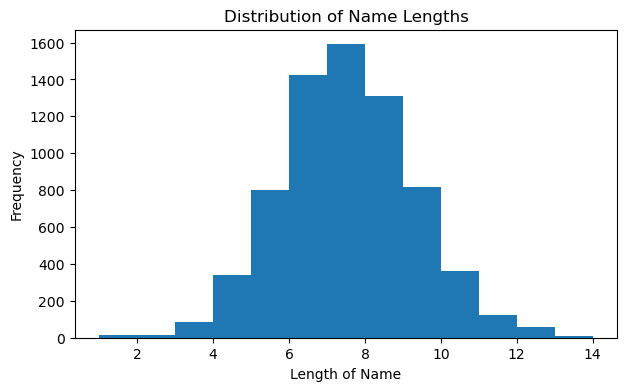

In [7]:
# Calculate name length
firstname['name_length'] = firstname['firstname'].apply(len)

# Histogram of name lengths
plt.figure(figsize=(7, 4))
firstname['name_length'].hist(bins=range(1, firstname['name_length'].max()+1))
plt.title('Distribution of Name Lengths')
plt.xlabel('Length of Name')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

In [8]:
firstname[firstname['name_length'] == 1]

,firstname,male,female,total_count,name_length
1274,g,282,4,286,1
1420,f,23,204,227,1
1680,m,87,69,156,1
2522,a,42,24,66,1
2640,x,28,33,61,1
2758,j,46,9,55,1
2790,n,40,14,54,1
3052,s,19,26,45,1
3090,y,42,2,44,1
3119,p,33,10,43,1


Apparently, there are 14 different names consisting of only one letter. This seems to be a bit strange.

I'm adding a gender ratio based on the male and female occurrences of each name. This can be seen like a probability that a person with a certain name is male. The ratio is between 0 and 1. Names with a ratio close to zero are predominantly female and name with a ratio close to one are predominantly male. There is no reasoning behind that and male and female could of course have been switched as well.

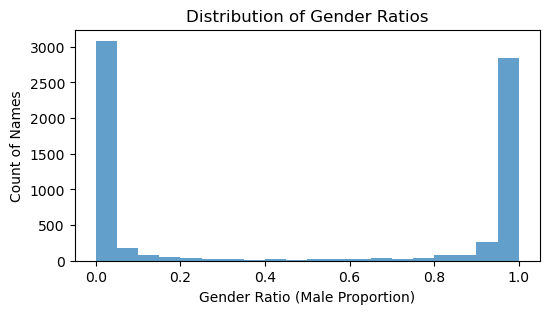

gender_category
Predominantly Female    3424
Predominantly Male      1481
Gender-Neutral           232
Name: count, dtype: int64


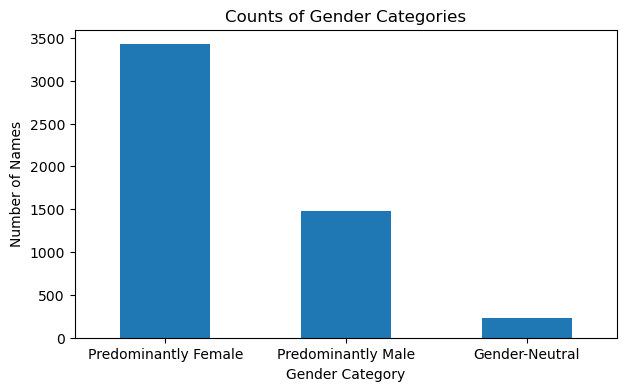

In [9]:
# Calculate the gender ratio
firstname['gender_ratio'] = firstname['male'] / (firstname['male'] + firstname['female'])

# Define categories based on gender_ratio
firstname['gender_category'] = pd.cut(firstname['gender_ratio'], bins=[0, 0.25, 0.75, 1], labels=['Predominantly Female', 'Gender-Neutral', 'Predominantly Male'], right=False)

# Visualization: Histogram of gender ratios
plt.figure(figsize=(6, 3))
firstname['gender_ratio'].hist(bins=20, alpha=0.7)
plt.title('Distribution of Gender Ratios')
plt.xlabel('Gender Ratio (Male Proportion)')
plt.ylabel('Count of Names')
plt.grid(False)
plt.show()

# Count of each category
category_counts = firstname['gender_category'].value_counts()
print(category_counts)

# Visualization: Bar chart of categories
plt.figure(figsize=(7, 4))
category_counts.plot(kind='bar')
plt.title('Counts of Gender Categories')
plt.xlabel('Gender Category')
plt.ylabel('Number of Names')
plt.xticks(rotation=0)
plt.show()

Based on these diagrams, we can see that most names are clearly predominantly female or male and that just a few are gender-neutral. Besides that, we can see how many names of which category are in the dataset.

Next, we are looking at the most common male, the most common female and the most common gender-neutral names.

In [10]:
# Top 10 male likely names, sorted by occurrence
top_male_names = firstname[firstname['gender_ratio'] > 0.75].sort_values(by='total_count', ascending=False).head(10)
print("Top 10 Male Names:")
print(top_male_names[['firstname', 'gender_ratio', 'total_count']])

# Top 10 female likely names, sorted by occurrence
top_female_names = firstname[firstname['gender_ratio'] < 0.25].sort_values(by='total_count', ascending=False).head(10)
print("\nTop 10 Female Names:")
print(top_female_names[['firstname', 'gender_ratio', 'total_count']])

# Gender-neutral names (ratio of 0.5), sorted by occurrence
gender_neutral_names = firstname[firstname['gender_ratio'] == 0.5].sort_values(by='total_count', ascending=False)
print("\nGender-Neutral Names with a Ratio of 0.5:")
print(gender_neutral_names[['firstname', 'gender_ratio', 'total_count']])

Top 10 Male Names:
   firstname  gender_ratio  total_count
1       jean      0.996548      1876091
2     pierre      0.996592      1480888
4   françois      0.994565      1094960
5     joseph      0.995293       901988
9      louis      0.996389       753218
11   jacques      0.996579       587577
12   antoine      0.996159       538156
13   nicolas      0.996427       409470
15    claude      0.985318       328964
16   charles      0.996492       277105

Top 10 Female Names:
     firstname  gender_ratio  total_count
0        marie      0.004226      2400467
3       jeanne      0.001606      1099162
6         anne      0.001809       817720
7   marguerite      0.001767       815300
8    catherine      0.001541       793671
10   françoise      0.001917       601320
14      louise      0.001883       361595
17   elisabeth      0.001567       225322
18   madeleine      0.001942       218363
22    claudine      0.001707       163991

Gender-Neutral Names with a Ratio of 0.5:
      firstnam

After that, I was asking myself the following question: If I would classify everybody according to the gender which is more common for the name, how many people would I classify correctly? The result of 99.41% shows that the name is by far a very good and strong indicator for the gender. That also implies that other factor are not absolutely necessary to predict the gender with a very high certainty.

In [11]:
# Add a column to determine which gender is dominant for each name
firstname['dominant_gender'] = firstname.apply(lambda x: 'male' if x['male'] > x['female'] else 'female', axis=1)

# Calculate the correct classification count based on the dominant gender
firstname['correct_classifications'] = firstname.apply(lambda x: x['male'] if x['dominant_gender'] == 'male' else x['female'], axis=1)

# Calculate the total number of correct classifications
total_correct = firstname['correct_classifications'].sum()

# Total number of people
total_people = firstname['total_count'].sum()

# Calculate the percentage of correctly classified individuals
percentage_correct = (total_correct / total_people) * 100

print(f"Total Correctly Classified: {total_correct}")
print(f"Total People: {total_people}")
print(f"Percentage Correctly Classified: {percentage_correct:.2f}%")

Total Correctly Classified: 26791855
Total People: 26950942
Percentage Correctly Classified: 99.41%


In [12]:
# delete the two columns from the last cell again as they are no longer required (they were just added to enable further exploration)
firstname = firstname.drop('dominant_gender', axis = 1)
firstname = firstname.drop('correct_classifications', axis = 1)

Finally, I asked myself the question how many people can be classified to one or the other gender with a probability of more than 99%.

In [13]:
# Filter the DataFrame for names where the gender ratio is >= 0.99 or <= 0.01
high_certainty_filter = (firstname['gender_ratio'] >= 0.99) | (firstname['gender_ratio'] <= 0.01)
high_certainty_df = firstname[high_certainty_filter]

# Sum the total_count of these filtered rows
high_certainty_count = high_certainty_df['total_count'].sum()

# Calculate the total count of all names
total_people = firstname['total_count'].sum()

# Calculate the percentage of people with >= 99% gender certainty
percentage_high_certainty = (high_certainty_count / total_people) * 100

# Print the result
print(f"Percentage of people with a gender likelihood of 99% or more: {percentage_high_certainty:.2f}%")

Percentage of people with a gender likelihood of 99% or more: 95.35%


As we can see, more than 95% of people can be classified to one gender with a very high certainty (probability of 99% or more). That gives us more reason to believe that we have to look only at the first name an not really something else. If the first name indicated that you belong to a certain gender with a probability of more than 99%, what else from the automatically transcribed text should then change your mind so that you would predict the other gender?

## 2.2 Exploration of the transcriptions dataset

Let's first have a look at the 'sex' column to find out whether there is only 'homme' and 'femme' in this column.

In [14]:
# Frequency distribution of the 'sex' column
print(transcriptions['sex'].value_counts())

sex
homme     125
femme     107
ambigu      9
Name: count, dtype: Int64


We can see that there are 9 rows where the sex is "ambigu". This is French and means as much as unclear or unknown. I should look at these rows in more detail. I will do that a bit below.

Before that, we explore the length of the groundtruth and the prediction. We see that the prediction (the automatically detected text) is usually longer than the true labeled text.

       groundtruth_length  prediction_length
count          241.000000         241.000000
mean            80.435685          88.099585
std             17.058142          20.820424
min             43.000000          43.000000
25%             71.000000          73.000000
50%             76.000000          85.000000
75%             86.000000          97.000000
max            144.000000         168.000000


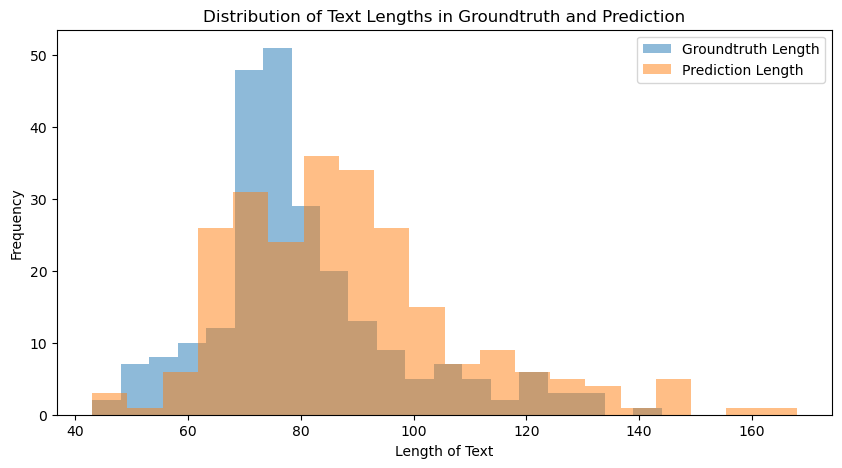

In [15]:
# Calculate the length of text in 'groundtruth' and 'prediction'
transcriptions['groundtruth_length'] = transcriptions['groundtruth'].apply(len)
transcriptions['prediction_length'] = transcriptions['prediction'].apply(len)

# Descriptive statistics for text lengths
print(transcriptions[['groundtruth_length', 'prediction_length']].describe())

# Visualize the distribution of text lengths
plt.figure(figsize=(10, 5))
plt.hist(transcriptions['groundtruth_length'], bins=20, alpha=0.5, label='Groundtruth Length')
plt.hist(transcriptions['prediction_length'], bins=20, alpha=0.5, label='Prediction Length')
plt.title('Distribution of Text Lengths in Groundtruth and Prediction')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.legend()
plt.show()

When reading some entries of the groundtruth and comparing it to the prediction column, I thought that the two versions often differ significantly and that often, they don't have that much in common. To quantify the difference, let's have a look at the Jaccard similarity between the two.

In [16]:
from sklearn.metrics import jaccard_score

# Function to calculate Jaccard similarity between two strings (set of words)
def jaccard_similarity(str1, str2):
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

# Apply function to each row
transcriptions['jaccard_similarity'] = transcriptions.apply(lambda x: jaccard_similarity(x['groundtruth'], x['prediction']), axis=1)

# Average Jaccard similarity
print(f"Average Jaccard similarity: {transcriptions['jaccard_similarity'].mean()}")

Average Jaccard similarity: 0.14003114683563508


We can see that often there are signficant differences between the groundtruth and the predictions (the automatic transcriptions). However, we do only have the automatically detected text for predicting the gender. One might think that this difference between the two shows us that it is better to use rather little information from the automatically detected text.

There are some rows having written "ambigu" in the "sex" column. I would like to know more about these entries.

In [17]:
transcriptions = transcriptions.drop(['groundtruth_length','prediction_length','jaccard_similarity'], axis = 1)

# save all the subject lines in a list so that I can verify easily that the adjustment worked later
subject_line_list = transcriptions[transcriptions['sex'] == 'ambigu']['subject_line'].tolist()

transcriptions[transcriptions['sex'] == 'ambigu']

,subject_line,groundtruth,prediction,sex
17,421b3e1f-ff91-4871-a8de-3af62c58e3bc,surname: Daniel firstname: Claude occupation: journalier link: chef age: 33,nom: Demil prénom: Claude date_naissance: 33 lieux_naissance: Yonne relation: chef,ambigu
59,8339da37-3493-4684-a9fd-090411f33d01,surname: Gorbinet firstname: Jeanne occupation: idem link: chef age: 66,nom: Gorbinet prénom: Jeanne date_naissance: 66 lieux_naissance: id relation: id,ambigu
94,e1e6fb82-6417-4dcf-8eaa-7d5a5e9f6551,surname: Roumeau firstname: Claude occupation: cultivateur link: chef age: 30 ans,nom: Roumeau prénom: Vaude date_naissance: 1804 lieux_naissance: Aulpares relation: Chef,ambigu
123,e6927138-689e-4d70-89c2-cf86f7171fd1,surname: Chardon firstname: Marie occupation: idem link: chef age: 84 ans,"nom: Chardon prénom: Marie date_naissance: 84 lieux_naissance: "" relation: D",ambigu
124,5b244d56-e1da-4b57-934a-0a1234f34709,surname: Grillé firstname: Emile occupation: idem link: idem employer: idem age: 2,"nom: d prénom: Emile date_naissance: 2 lieux_naissance: d relation: "" profession: """,ambigu
130,623f7836-8a46-4078-914e-f3cb9bb51c6e,surname: Martin firstname: Marie occupation: idem link: idem age: 45,nom: Martin prénom: Marie date_naissance: 47 lieux_naissance: P id état_civil: id profession: id,ambigu
196,91b1d765-2195-462d-a85b-72233327ff4d,surname: Pénot firstname: Claude occupation: s.p link: enfant age: 13,nom: Pirot prénom: Claude date_naissance: 1303 lieux_naissance: id relation: enfant,ambigu
204,a17f5fb3-c879-4a9a-a063-e3a43f4f4a3c,surname: Coq firstname: Antonie occupation: idem link: idem employer: idem age: 16,nom: d prénom: Entonie date_naissance: 16 lieux_naissance: d relation: f,ambigu
230,e925d46e-1ea7-4537-986e-0fe062d64fa2,surname: Clayeux firstname: Claude occupation: idem link: idem employer: idem age: 13,nom: Clayeux prénom: Claude date_naissance: 13 lieux_naissance: P relation: a,ambigu


# 3. Data Cleaning and Preprocessing

I start with an issue that some entries have "ambigu" as sex. The output of the cell above shows us that the gender of these 9 rows can indeed be labeled. According to the groundtruth, these people all have names for which the firstname dataset says that one gender is particularly likely. These genders are added manually with the next steps.

In the beginning, I left this step out and just continued with transcriptions['target'] = np.where(transcriptions['sex'] == 'homme', 1, 0) down below. This lead to some mistakes and a lower accuracy. We see once more how helpful exploratory data analysis it.

In [18]:
# to find out the most likely gender of those people with ambigu in the sex column
names_to_check = ['claude', 'jeanne', 'marie','emile','antonie']

# Filter the DataFrame to only include rows with these specific names
firstname[firstname['firstname'].isin(names_to_check)]

,firstname,male,female,total_count,name_length,gender_ratio,gender_category
0,marie,10145,2390322,2400467,5,0.004226,Predominantly Female
3,jeanne,1765,1097397,1099162,6,0.001606,Predominantly Female
15,claude,324134,4830,328964,6,0.985318,Predominantly Male
59,emile,65749,444,66193,5,0.993292,Predominantly Male
1086,antonie,23,394,417,7,0.055156,Predominantly Female


In [19]:
# add the code here to assign the right gender to the rows from above
transcriptions.loc[transcriptions['subject_line'] == '421b3e1f-ff91-4871-a8de-3af62c58e3bc', 'sex'] = 'homme'
transcriptions.loc[transcriptions['subject_line'] == '8339da37-3493-4684-a9fd-090411f33d01', 'sex'] = 'femme'
transcriptions.loc[transcriptions['subject_line'] == 'e1e6fb82-6417-4dcf-8eaa-7d5a5e9f6551', 'sex'] = 'homme'
transcriptions.loc[transcriptions['subject_line'] == 'e6927138-689e-4d70-89c2-cf86f7171fd1', 'sex'] = 'femme'
transcriptions.loc[transcriptions['subject_line'] == '5b244d56-e1da-4b57-934a-0a1234f34709', 'sex'] = 'homme'
transcriptions.loc[transcriptions['subject_line'] == '623f7836-8a46-4078-914e-f3cb9bb51c6e', 'sex'] = 'femme'
transcriptions.loc[transcriptions['subject_line'] == '91b1d765-2195-462d-a85b-72233327ff4d', 'sex'] = 'homme'
transcriptions.loc[transcriptions['subject_line'] == 'a17f5fb3-c879-4a9a-a063-e3a43f4f4a3c', 'sex'] = 'femme'
transcriptions.loc[transcriptions['subject_line'] == 'e925d46e-1ea7-4537-986e-0fe062d64fa2', 'sex'] = 'homme'

In [20]:
# verify that adding the genders manually worked
transcriptions[transcriptions['subject_line'].isin(subject_line_list)]

,subject_line,groundtruth,prediction,sex
17,421b3e1f-ff91-4871-a8de-3af62c58e3bc,surname: Daniel firstname: Claude occupation: journalier link: chef age: 33,nom: Demil prénom: Claude date_naissance: 33 lieux_naissance: Yonne relation: chef,homme
59,8339da37-3493-4684-a9fd-090411f33d01,surname: Gorbinet firstname: Jeanne occupation: idem link: chef age: 66,nom: Gorbinet prénom: Jeanne date_naissance: 66 lieux_naissance: id relation: id,femme
94,e1e6fb82-6417-4dcf-8eaa-7d5a5e9f6551,surname: Roumeau firstname: Claude occupation: cultivateur link: chef age: 30 ans,nom: Roumeau prénom: Vaude date_naissance: 1804 lieux_naissance: Aulpares relation: Chef,homme
123,e6927138-689e-4d70-89c2-cf86f7171fd1,surname: Chardon firstname: Marie occupation: idem link: chef age: 84 ans,"nom: Chardon prénom: Marie date_naissance: 84 lieux_naissance: "" relation: D",femme
124,5b244d56-e1da-4b57-934a-0a1234f34709,surname: Grillé firstname: Emile occupation: idem link: idem employer: idem age: 2,"nom: d prénom: Emile date_naissance: 2 lieux_naissance: d relation: "" profession: """,homme
130,623f7836-8a46-4078-914e-f3cb9bb51c6e,surname: Martin firstname: Marie occupation: idem link: idem age: 45,nom: Martin prénom: Marie date_naissance: 47 lieux_naissance: P id état_civil: id profession: id,femme
196,91b1d765-2195-462d-a85b-72233327ff4d,surname: Pénot firstname: Claude occupation: s.p link: enfant age: 13,nom: Pirot prénom: Claude date_naissance: 1303 lieux_naissance: id relation: enfant,homme
204,a17f5fb3-c879-4a9a-a063-e3a43f4f4a3c,surname: Coq firstname: Antonie occupation: idem link: idem employer: idem age: 16,nom: d prénom: Entonie date_naissance: 16 lieux_naissance: d relation: f,femme
230,e925d46e-1ea7-4537-986e-0fe062d64fa2,surname: Clayeux firstname: Claude occupation: idem link: idem employer: idem age: 13,nom: Clayeux prénom: Claude date_naissance: 13 lieux_naissance: P relation: a,homme


After adding the gender manually, I like to change this column. For more clarity, I call it 'target'. 1 means male, 0 means female.

In [21]:
# create a new boolean column for the sex (0: homme, 1: femme)
transcriptions['target'] = np.where(transcriptions['sex'] == 'homme', 1, 0)

In [22]:
# drop the 'sex' column to have only a numeric value as target variable
transcriptions = transcriptions.drop('sex', axis = 1)
transcriptions.head()

,subject_line,groundtruth,prediction,target
0,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,surname: Chardon firstname: Marie occupation: idem link: fille age: 30,"nom: Chardon prénom: Marie date_naissance: 30 lieux_naissance: """,0
1,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,surname: Lhopital firstname: Louis-Jean occupation: sp link: chef age: 67,nom: Lhopital prénom: Louis Jean date_naissance: 67 lieux_naissance: Sn employeur: ahef,1
2,e6a279da-9b6f-4f49-b498-64857bc50d1e,surname: Papin firstname: Marie occupation: idem link: idem employer: idem age: 15,nom: Pyrin prénom: Marie date_naissance: 55 relation: d,0
3,7534deca-39e8-4f00-be17-c12460015de1,surname: Lavocat firstname: Marie link: femme birth_date: 1875 lob: Rigny,nom: Lavocat prénom: Marie date_naissance: 1875 lieux_naissance: Rigny profession: '',0
4,ef334a66-a504-418a-9872-e7c9db923488,surname: Benne firstname: Marguerite age: 78,nom: Benne prénom: Marguerite date_naissance: 78 lieux_naissance: id relation: '',0


I feel like the 'subject_line' leads to more disorder and mess when looking at the data frame. As it does not have a specific purpose any more, I drop it. Within the pandas data frame, there is still the index identifying each row.

In [23]:
# removing the column 'subject_line' as it is just an identifier without importance for the model training
transcriptions.drop('subject_line', axis=1, inplace=True)
transcriptions.head()

,groundtruth,prediction,target
0,surname: Chardon firstname: Marie occupation: idem link: fille age: 30,"nom: Chardon prénom: Marie date_naissance: 30 lieux_naissance: """,0
1,surname: Lhopital firstname: Louis-Jean occupation: sp link: chef age: 67,nom: Lhopital prénom: Louis Jean date_naissance: 67 lieux_naissance: Sn employeur: ahef,1
2,surname: Papin firstname: Marie occupation: idem link: idem employer: idem age: 15,nom: Pyrin prénom: Marie date_naissance: 55 relation: d,0
3,surname: Lavocat firstname: Marie link: femme birth_date: 1875 lob: Rigny,nom: Lavocat prénom: Marie date_naissance: 1875 lieux_naissance: Rigny profession: '',0
4,surname: Benne firstname: Marguerite age: 78,nom: Benne prénom: Marguerite date_naissance: 78 lieux_naissance: id relation: '',0


Now I'm lowercasing the 'groundtruth' and 'prediction' columns because the firstname dataset also contains only names with lower case letters. Besides that, I rename the column 'prediction' by 'detected_text' to avoid confusion with the target variable that I want to predict here.

In [24]:
# Lowercase the text in 'groundtruth' and 'prediction' columns
transcriptions['groundtruth'] = transcriptions['groundtruth'].str.lower()
transcriptions['prediction'] = transcriptions['prediction'].str.lower()

# Rename the prediction column for more clarity and to avoid confusion with the prediction of the gender that I want to make
transcriptions.rename(columns = {'prediction':'detected_text'}, inplace = True) 
transcriptions.head()

,groundtruth,detected_text,target
0,surname: chardon firstname: marie occupation: idem link: fille age: 30,"nom: chardon prénom: marie date_naissance: 30 lieux_naissance: """,0
1,surname: lhopital firstname: louis-jean occupation: sp link: chef age: 67,nom: lhopital prénom: louis jean date_naissance: 67 lieux_naissance: sn employeur: ahef,1
2,surname: papin firstname: marie occupation: idem link: idem employer: idem age: 15,nom: pyrin prénom: marie date_naissance: 55 relation: d,0
3,surname: lavocat firstname: marie link: femme birth_date: 1875 lob: rigny,nom: lavocat prénom: marie date_naissance: 1875 lieux_naissance: rigny profession: '',0
4,surname: benne firstname: marguerite age: 78,nom: benne prénom: marguerite date_naissance: 78 lieux_naissance: id relation: '',0


In [25]:
firstname.head()

,firstname,male,female,total_count,name_length,gender_ratio,gender_category
0,marie,10145,2390322,2400467,5,0.004226,Predominantly Female
1,jean,1869615,6476,1876091,4,0.996548,Predominantly Male
2,pierre,1475841,5047,1480888,6,0.996592,Predominantly Male
3,jeanne,1765,1097397,1099162,6,0.001606,Predominantly Female
4,françois,1089009,5951,1094960,8,0.994565,Predominantly Male


When looking at the firstname dataset, I already know at this point that I don't need the 'gender_category' any more. That's why I drop it.

In [26]:
firstname = firstname.drop('gender_category', axis = 1)

# 4. First approach: Name extraction and a very simple ML model

## 4.1 Extraction of the first name

First, we extract the firstname from the 'detected_text' column. That is done by using the str.extract() function. After that, a - in the name is replaced by a space.

In [27]:
# Extract the first name
transcriptions['extracted_firstname'] = transcriptions['detected_text'].str.extract(r'prénom:\s*([^\s]+)')
transcriptions['extracted_firstname'] = transcriptions['extracted_firstname'].str.replace('-', ' ', regex=False)

After that, it's important to find out which of the extracted names can be found in the firstname dataset and which of them are not. For that, I create a list containing all the names from the firstname data frame.

Then, a new column 'name_found' is added, indicating whether the extracted name has been found (True) or not (False).

In [28]:
# Convert the list of valid firstnames to a set for faster membership testing
valid_names = set(firstname['firstname'])

# Check if each name in 'extracted_firstname' is found in the 'valid_names' set
transcriptions['name_found'] = transcriptions['extracted_firstname'].isin(valid_names)
transcriptions.head()

,groundtruth,detected_text,target,extracted_firstname,name_found
0,surname: chardon firstname: marie occupation: idem link: fille age: 30,"nom: chardon prénom: marie date_naissance: 30 lieux_naissance: """,0,marie,True
1,surname: lhopital firstname: louis-jean occupation: sp link: chef age: 67,nom: lhopital prénom: louis jean date_naissance: 67 lieux_naissance: sn employeur: ahef,1,louis,True
2,surname: papin firstname: marie occupation: idem link: idem employer: idem age: 15,nom: pyrin prénom: marie date_naissance: 55 relation: d,0,marie,True
3,surname: lavocat firstname: marie link: femme birth_date: 1875 lob: rigny,nom: lavocat prénom: marie date_naissance: 1875 lieux_naissance: rigny profession: '',0,marie,True
4,surname: benne firstname: marguerite age: 78,nom: benne prénom: marguerite date_naissance: 78 lieux_naissance: id relation: '',0,marguerite,True


Before applying it to the names that were not found, we need to define the following function. This function utilizes the Levenshtein distance to find the closest / most similar name in the firstname dataframe. The Levenshtein distance is a measure of the minimum number of single-character edits (insertions, deletions, or substitutions) required to change one word or text string into another. Further information can be found here: https://en.wikipedia.org/wiki/Levenshtein_distance

Even though it can be expected that the Levenshtein distance cannot find the original name from the groundtruth for every name that was not found, I would like to argue that it is suitable because of the following reason: In quite some cases, the automatic transcription of the handwriting just messes up one letter of the firstname. In this case, it is likely that the right name can be found using this technique.

In [29]:
# define a function to get the name which is closest to the name that has not been found
def find_closest_name(bad_name, firstname_df):
    closest_name = None
    min_distance = float('inf')  # Start with an infinitely bad distance.
    
    for name in firstname_df['firstname']:
        dist = levenshtein_distance(bad_name, name)
        if dist < min_distance:
            min_distance = dist
            closest_name = name

    return closest_name

In the following, we define a function that decides when to call the function from above and when not. Finally, the corrected_firstname is saved in a separate column.
In the end of the cell, we output a few rows of the dataset where the name has not be found. Like that, we can see that a few names could be corrected so that they match the groundtruth. Others however do not match the groundtruth successfully. The reasons for that is probably, that the firstname in the automatically detected text is too far away from the groundtruth.

In [30]:
# define a function that calls find_closest_name() if necessary and otherwise just returns the extracted-firstname
def get_corrected_name(row, firstname_df):
    if not row['name_found']:  # If the name was not found
        return find_closest_name(row['extracted_firstname'], firstname_df)
    else:
        return row['extracted_firstname']

# apply the function and save the results in a new column called 'corrected_firstname'
transcriptions['corrected_firstname'] = transcriptions.apply(get_corrected_name, args=(firstname,), axis=1)
transcriptions[transcriptions['name_found'] == False].head(10)

,groundtruth,detected_text,target,extracted_firstname,name_found,corrected_firstname
18,surname: vivier firstname: antoine occupation: cultivateur link: chef age: 45 birth_date: 1841,nom: vivier prénom: angène date_naissance: 180n lieux_naissance: aulgique état_civil: d relation: ch,1,angène,False,angèle
24,surname: debouesse firstname: alexandre occupation: couvreur link: chef employer: patron age: 42,nom: debouese prénom: herandre date_naissance: 42 lieux_naissance: chef profession: patron,1,herandre,False,leandre
25,surname: martin firstname: marguerite occupation: idem link: épouse employer: idem age: 30,nom: marhi prénom: oarguerite date_naissance: 30 lieux_naissance: d relation: ep,0,oarguerite,False,marguerite
34,surname: aumaitre firstname: virginie link: ép birth_date: 1852 lob: saint-avit puy-de-dome,prénom: vigmie date_naissance: 1852 lieux_naissance: savit relation: ep,0,vigmie,False,mimie
62,surname: daviot firstname: jean-marie occupation: domestique de ferme link: domestique de ferme age: 25,nom: davist prénom: jean-marie date_naissance: 25 lieux_naissance: d,1,jean marie,False,jeannemarie
65,surname: fleury firstname: antoine link: idem age: 7 ans,nom: fleury prénom: angloise date_naissance: 7 44 lieux_naissance: id état_civil: ',1,angloise,False,aloise
69,surname: pénot firstname: françois occupation: métayer link: chef age: 39,nom: pénot prénom: feris date_naissance: 3903 état_civil: m relation: metages relation: chef,1,feris,False,denis
82,surname: brun firstname: jacques occupation: garde-champêtre link: chef age: 50 ans,nom: brun prénom: jregues date_naissance: 5 0nne état_civil: chef,1,jregues,False,jacques
94,surname: roumeau firstname: claude occupation: cultivateur link: chef age: 30 ans,nom: roumeau prénom: vaude date_naissance: 1804 lieux_naissance: aulpares relation: chef,1,vaude,False,haude
104,surname: pégand firstname: gilbert occupation: culivateur link: chef employer: patron age: 55,nom: pegand prénom: gilbeuse date_naissance: 85 lieux_naissance: chef relation: patron,1,gilbeuse,False,gilberte


## 4.2 Merging the datasets

Next, we merge the 'transcriptions' and the 'firstname' dataset. We use transcriptions['corrected_firstname'] and firstname['firstname'] as key for this merge. Like that, we have a gender_ratio in each row which we can use as learning feature in the next step. I delete columns that are not required and more and which just comprimise the overview over the dataframe.

In [31]:
# Merge transcriptions with firstname on the extracted_firstname column
df_merged = pd.merge(transcriptions, firstname, left_on='corrected_firstname', right_on='firstname', how='left')

df_merged = df_merged.drop(['firstname', 'male', 'female','total_count'], axis=1)

df_merged.head()

,groundtruth,detected_text,target,extracted_firstname,name_found,corrected_firstname,name_length,gender_ratio
0,surname: chardon firstname: marie occupation: idem link: fille age: 30,"nom: chardon prénom: marie date_naissance: 30 lieux_naissance: """,0,marie,True,marie,5,0.004226
1,surname: lhopital firstname: louis-jean occupation: sp link: chef age: 67,nom: lhopital prénom: louis jean date_naissance: 67 lieux_naissance: sn employeur: ahef,1,louis,True,louis,5,0.996389
2,surname: papin firstname: marie occupation: idem link: idem employer: idem age: 15,nom: pyrin prénom: marie date_naissance: 55 relation: d,0,marie,True,marie,5,0.004226
3,surname: lavocat firstname: marie link: femme birth_date: 1875 lob: rigny,nom: lavocat prénom: marie date_naissance: 1875 lieux_naissance: rigny profession: '',0,marie,True,marie,5,0.004226
4,surname: benne firstname: marguerite age: 78,nom: benne prénom: marguerite date_naissance: 78 lieux_naissance: id relation: '',0,marguerite,True,marguerite,10,0.001767


## 4.3 Logistic Regression

At this point in time, we can start to learn our first model. For the beginning, I have chosen a logistic regression which is specifically designed for binary classification problems like the one we are dealing with here. Further thoughts about the model choice and different advantages and disadvantages of the different models in this notebook are provided in the project report.

We are using only the 'gender_ratio' as a feature. We have seen that this one is increadibly much indicative for the gender. As the detected text often differs significantly from the groundtruth, it is advisable not to use too much information from it.

We're using a simple train-test split and print the classification report in the end.

In [32]:
# Features and Target
X = df_merged[['gender_ratio']]  #  features
y = df_merged['target']  # y is the target variable

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94        23
           1       0.96      0.92      0.94        26

    accuracy                           0.94        49
   macro avg       0.94      0.94      0.94        49
weighted avg       0.94      0.94      0.94        49



Next, we would like to get more robust results by using cross validation. This makes sense as we have a rather small train and test set and so we can make sure that each row ends up in both sets at some point.

In [33]:
# Features and Target
X = df_merged[['gender_ratio']]  # features
y = df_merged['target']  # target variable

# Initialize logistic regression model
model = LogisticRegression()

# Perform 5-fold cross-validation
scores = cross_val_score(model, X, y, cv=5)

# Print the accuracy for each fold
print("Accuracy for each fold: ", scores)

# Print mean accuracy and standard deviation
print("Mean cross-validation accuracy: ", np.mean(scores))
print("Standard deviation of cross-validation accuracy: ", np.std(scores))

Accuracy for each fold:  [0.97959184 0.95833333 0.95833333 0.95833333 0.9375    ]
Mean cross-validation accuracy:  0.9584183673469389
Standard deviation of cross-validation accuracy:  0.013311014917924819


We can see that the accuracy is between 93% and 98% at each time with an average accuracy of about 96%. Those number can differ slightly when adjusting the random_state above.

We can summarize that we can achieve very good results with a simple model after we have done extensive data exploration, cleaning and preprocessing.

## 4.4 Decision Stump

Next, I wanted to try an even simpler model. In the next cell, we are learning a decision stump (a decision tree with a depth of 1).

In [34]:
X = df_merged[['gender_ratio']]  # Features
y = df_merged['target']  # Target variable

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the decision stump
stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)

# Predict on the test set
y_pred_stump = stump.predict(X_test)

# Evaluate the model
print("Decision Stump Classification Report:")
print(classification_report(y_test, y_pred_stump))

Decision Stump Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        23
           1       0.96      0.92      0.94        26

    accuracy                           0.94        49
   macro avg       0.94      0.94      0.94        49
weighted avg       0.94      0.94      0.94        49



As we can see, with a decision stump we can achieve the exact same results as with the logistic regression. This is little surprising as we had only one feature used for the logistic regression.

[Text(0.5, 0.75, 'gender_ratio <= 0.511\ngini = 0.497\nsamples = 192\nvalue = [88, 104]\nclass = 1'),
 Text(0.25, 0.25, 'gini = 0.137\nsamples = 95\nvalue = [88, 7]\nclass = 0'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 97\nvalue = [0, 97]\nclass = 1')]

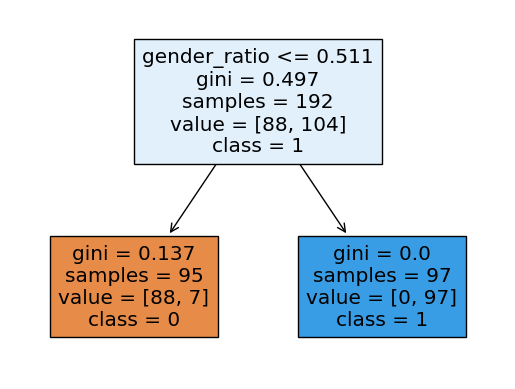

In [35]:
tree.plot_tree(stump,
           feature_names = ['gender_ratio'], 
           class_names=['0', '1'],
           filled = True)

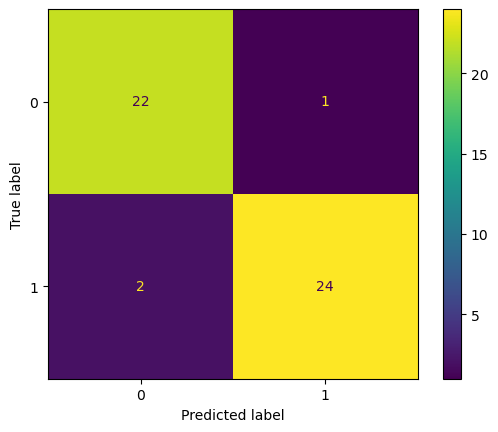

In [36]:
cm = confusion_matrix(y_test, y_pred_stump)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [37]:
y_scores = stump.predict_proba(X_test)[:, 1]  # get the score for the positive class

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

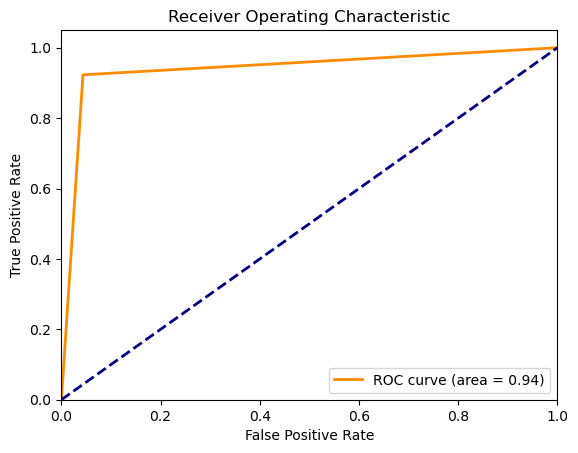

In [38]:
plt.figure()
lw = 2  # line width
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

We are creating a data frame with columns that are relevant to examing the results of the prediction. That included the real names (groundtruth), the extracted names and the corrected names as well as our the one corresponding feature. Lastly, there are the predicted and the real label (y).

In [39]:
results_df = pd.DataFrame({
    'groundtruth': df_merged.loc[y_test.index, 'groundtruth'],
    'extracted_firstname': df_merged.loc[y_test.index, 'extracted_firstname'],
    'corrected_firstname': df_merged.loc[y_test.index, 'corrected_firstname'],
    'gender_ratio': X_test['gender_ratio'],
    'y_pred': y_pred,
    'y_test': y_test
}, index=y_test.index)

results_df.head()

,groundtruth,extracted_firstname,corrected_firstname,gender_ratio,y_pred,y_test
24,surname: debouesse firstname: alexandre occupation: couvreur link: chef employer: patron age: 42,herandre,leandre,0.948718,1,1
6,surname: bizet firstname: louis link: idem age: 9,louis,louis,0.996389,1,1
222,surname: mimerel firstname: pierre link: fils age: 8,pierre,pierre,0.996592,1,1
208,surname: aubouër firstname: claudine occupation: néant link: enfant age: 16,claudine,claudine,0.001707,0,0
236,surname: burlurut firstname: pétronille occupation: sans profession link: épouse age: 61 ans,gihromille,pétronille,0.002291,0,0


With the following cell, we can have a look specifically at those name that are labeled incorrectly.

In [40]:
# filter to those names which were classified incorrectly
results_df[results_df['y_pred'] != results_df['y_test']]

,groundtruth,extracted_firstname,corrected_firstname,gender_ratio,y_pred,y_test
197,surname: boutot firstname: françoise occupation: domest. link: domest. employer: lavany age: 16,faul,paul,0.996657,1,0
18,surname: vivier firstname: antoine occupation: cultivateur link: chef age: 45 birth_date: 1841,angène,angèle,0.003936,0,1
126,surname: ouverkierviez firstname: stanislas link: fils birth_date: 1924 lob: cerny-lès-bucy,mamiolas,mariola,0.000000,0,1


By comparing the groundtruth with the extracted firstname and the corrected firstname, we can see the following: Usually, the automatically detected firstname is too far away from the true name so that it's impossible to come back to the true name through the Levenshtein distance. Then, if the corrected_firstname has the wrong gender (the wrong gender ratio) it is leading to a misclassification.

Next, I would like to make sure that the performance is similar (the same) to logistic regression by performing 5-fold cross-validation as well.

In [41]:
# Initialize the decision stump
stump = DecisionTreeClassifier(max_depth=1, random_state=42)

# Perform 5-fold cross-validation
scores = cross_val_score(stump, X, y, cv=5)

# Print the accuracy for each fold
print("Accuracy for each fold:")
print(scores)

# Print mean accuracy and standard deviation
print("Mean cross-validation accuracy:", scores.mean())
print("Standard deviation of cross-validation accuracy:", scores.std())

Accuracy for each fold:
[0.97959184 0.95833333 0.95833333 0.95833333 0.9375    ]
Mean cross-validation accuracy: 0.9584183673469389
Standard deviation of cross-validation accuracy: 0.013311014917924819


As we can see, also the 5-fold cross validation brings exactly the same results as the logistic regression. It’s important to mention that I cannot guarantee that logistic regression and decision stump are always exactly the same (maybe there would be a few minor differences when using it on a larger dataset). But with our data it was always the same.

Let's plot a confusion matrix to vizualize what has been labeled correctly and incorrectly:

### What does this show us?

We have seen that we were able to achieve around 95% of accuracy (90% to 100% depending on the random state) with only a decision stump. A decision stump is probably the easiest machine learning model out there. And especially because of this simplicity it has a bunch of advantages. These advantages are not only a short runtime and low required resourced but also explainability. It can be explained very easily how this model comes to its accurate decision (even to people who are not not into data science). Further thougths on that can be found in the enclosed project report.

At this point, I expect this model to be the best because of that. Nevertheless, I would like to try something that is very different. I will try to solve the same problem using a BERT transformer model.

# 5. Second approach: Transformer-based model

I'm curious to find out whether a transformer model cannot achieve an accuracy which is a little better than the others. (A significant perfomance improvement seems to be not possible when looking at the accuracy from above.) I will train the model not only on the firstname but rather on the whole automatically transcribed predictions. Like that, the model can take more information into account. Maybe it can make sense of the profession or even the age and then improve the prediction based on that. However, I would be very surprised if that really improves anything.

To fine-tune a BERT, the following things are important:
- it is important to lowercase the text when training fine-tuning an uncased model
- removal of special characters is not necessary and might even reduce the semantics / the meaning of the text
- tokenization: it's important to use a BertTokenizer
- stop word removal, stemming, lemmatization are usually not required

When looking at these requirements, there is nothing specific that we need to change on our datasets, we just need to think about using the Bert Tokenizer.

Please make sure that you have all the following packages installed in your environment if you want to run the remaining cells of the notebook.

In [42]:
# package import
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
from transformers import BertForSequenceClassification
import torch
from transformers import AdamW
from tqdm import tqdm

Let's just have a short look at the dataframe that we use for the training of our BERT classifier.

In [43]:
# just display the dataframe that is used once more
df_merged.head()

,groundtruth,detected_text,target,extracted_firstname,name_found,corrected_firstname,name_length,gender_ratio
0,surname: chardon firstname: marie occupation: idem link: fille age: 30,"nom: chardon prénom: marie date_naissance: 30 lieux_naissance: """,0,marie,True,marie,5,0.004226
1,surname: lhopital firstname: louis-jean occupation: sp link: chef age: 67,nom: lhopital prénom: louis jean date_naissance: 67 lieux_naissance: sn employeur: ahef,1,louis,True,louis,5,0.996389
2,surname: papin firstname: marie occupation: idem link: idem employer: idem age: 15,nom: pyrin prénom: marie date_naissance: 55 relation: d,0,marie,True,marie,5,0.004226
3,surname: lavocat firstname: marie link: femme birth_date: 1875 lob: rigny,nom: lavocat prénom: marie date_naissance: 1875 lieux_naissance: rigny profession: '',0,marie,True,marie,5,0.004226
4,surname: benne firstname: marguerite age: 78,nom: benne prénom: marguerite date_naissance: 78 lieux_naissance: id relation: '',0,marguerite,True,marguerite,10,0.001767


Information on PyTorch datasets and dataloaders can for example be found here: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

Information on the transformer tokenizer can be found here: https://huggingface.co/docs/transformers/main_classes/tokenizer

The following cell sets up a PyTorch dataset and dataloader. It initializes a tokenizer to convert text into a format suitable for BERT, defines a custom dataset class to manage data extraction and preprocessing, and creates a dataloader to handle batching and shuffling of data for efficient model training.

In [44]:
# Initialize the tokenizer for 'bert-base-uncased'
# converts text into tokens that can be used by the BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define a custom dataset class that inherits from PyTorch's Dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        # Constructor for the CustomDataset class to initialize its properties.
        self.data = dataframe

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.data)

    def __getitem__(self, idx):
        # Extract data from the DataFrame for the given index
        text = self.data.iloc[idx]['detected_text']
        gender_ratio = self.data.iloc[idx]['gender_ratio']
        target = self.data.iloc[idx]['target']

        # BERT input formatting
        inputs = tokenizer(text, padding='max_length', max_length=256, truncation=True, return_tensors="pt")
        input_ids = inputs['input_ids'].squeeze(0)
        attention_mask = inputs['attention_mask'].squeeze(0)

        # Return a dictionary of inputs and the target label
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'gender_ratio': gender_ratio,
            'labels': torch.tensor(target, dtype=torch.long),
            'text': text
        }
    
    def get_labels(self):
        # Method to retrieve ground truth labels
        return self.data['target'].tolist()

# Create an instance of the dataset with a merged DataFrame
dataset = CustomDataset(df_merged)

# Create a DataLoader to handle batching of data samples for model training
# batch_size: Number of samples per batch to load (32 in this case)
# shuffle: Set to True to have the data reshuffled at every epoch
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Next, we initialize a pretrained uncased BERT model and configure it in a way that it can distinguish between two classes. It sets the model device to CPU as no GPU was available for training. (This can be adjusted if wished.)

In [45]:
# Initialize BERT with a classification head
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  # num_labels = 2 for binary classification

# Select CPU as device (I don't have any GPU available)
device = torch.device("cpu")
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

Information on the AdamW optimizer can for example be found here: https://huggingface.co/docs/bitsandbytes/main/en/reference/optim/adamw

Information on how to train a PyTorch classifier can for example be found here: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

This code sets up and runs the training process for a BERT model for binary classification. It starts by initializing an optimizer for model parameters using a specific learning rate. The dataset is split into training and testing sets, and corresponding dataloaders are created to manage data batching and loading during training and testing phases. The model uses 20 epochs for training leading to a rather small loss in the end.

In [46]:
optimizer = AdamW(model.parameters(), lr=2e-5)

# Split dataset into train and test sets
train_df, test_df = train_test_split(df_merged, test_size=0.2, random_state=42)  # Adjust test_size as needed

# Create dataloaders for train and test sets
train_dataset = CustomDataset(train_df)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = CustomDataset(test_df)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # No need to shuffle for testing

for epoch in range(20):  # Number of epochs
    model.train()
    total_loss = 0
    for batch in tqdm(train_dataloader):
        # Move only tensor objects to the device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Perform forward propagation
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        # Extract the loss and perform backpropagation
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Print average loss for the epoch
    print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_dataloader)}')

/opt/anaconda3/envs/ensae_nlp_env/lib/python3.12/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 6/6 [00:51<00:00,  8.56s/it]


Epoch 1, Loss: 0.6881997386614481


100%|██████████| 6/6 [00:49<00:00,  8.19s/it]


Epoch 2, Loss: 0.6525344749291738


100%|██████████| 6/6 [00:49<00:00,  8.30s/it]


Epoch 3, Loss: 0.5889157950878143


100%|██████████| 6/6 [00:49<00:00,  8.20s/it]


Epoch 4, Loss: 0.4800254652897517


100%|██████████| 6/6 [00:48<00:00,  8.13s/it]


Epoch 5, Loss: 0.2738666906952858


100%|██████████| 6/6 [00:48<00:00,  8.10s/it]


Epoch 6, Loss: 0.1472624440987905


100%|██████████| 6/6 [00:49<00:00,  8.29s/it]


Epoch 7, Loss: 0.09957132178048293


100%|██████████| 6/6 [00:50<00:00,  8.44s/it]


Epoch 8, Loss: 0.06204489183922609


100%|██████████| 6/6 [00:49<00:00,  8.21s/it]


Epoch 9, Loss: 0.035742249650259815


100%|██████████| 6/6 [00:49<00:00,  8.32s/it]


Epoch 10, Loss: 0.030557054715851944


100%|██████████| 6/6 [00:49<00:00,  8.20s/it]


Epoch 11, Loss: 0.01657043754433592


100%|██████████| 6/6 [00:49<00:00,  8.22s/it]


Epoch 12, Loss: 0.01172170244778196


100%|██████████| 6/6 [00:50<00:00,  8.40s/it]


Epoch 13, Loss: 0.04294340576355656


100%|██████████| 6/6 [00:50<00:00,  8.33s/it]


Epoch 14, Loss: 0.02275369440515836


100%|██████████| 6/6 [00:52<00:00,  8.69s/it]


Epoch 15, Loss: 0.014687586498136321


100%|██████████| 6/6 [00:48<00:00,  8.15s/it]


Epoch 16, Loss: 0.007976063061505556


100%|██████████| 6/6 [00:48<00:00,  8.00s/it]


Epoch 17, Loss: 0.0066981759543220205


100%|██████████| 6/6 [00:49<00:00,  8.27s/it]


Epoch 18, Loss: 0.005745590664446354


100%|██████████| 6/6 [00:48<00:00,  8.09s/it]


Epoch 19, Loss: 0.007789018951977293


100%|██████████| 6/6 [00:51<00:00,  8.54s/it]

Epoch 20, Loss: 0.00444904004689306


The following cell allows to evaluate the model on the test set:

In [47]:
# Evaluate the model on the test set

# Switch the model to evaluation mode
model.eval()

for batch in test_dataloader:
    # Move only tensor objects to the device
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    # Disable gradient calculations to reduce memory usage
    with torch.no_grad():
        # Forward pass through the model to get the logits
        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

    # Extract logits from the model outputs
    logits = outputs.logits

    # Convert logits to predicted classes by finding the index (class) with the maximum logit score
    predictions = torch.argmax(logits, dim=-1)

Let's create a dataframe based on the predictions so that we can have a clean output down below.

In [48]:
# First, ensure all test predictions are gathered
all_preds = []
all_true_labels = []
all_texts = []
all_firstnames = []

for batch in test_dataloader:

    # Move only tensor objects to the device
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    all_preds.extend(predictions.cpu().numpy())
    all_true_labels.extend(batch['labels'].cpu().numpy())
    all_texts.extend(batch['text'])
    #all_firstnames.extend(batch['firstname'])

# Now, create a DataFrame with this data
results_df = pd.DataFrame({
    'Detected Text': all_texts,
    'True Label': all_true_labels,
    'Predicted Label': all_preds
})

In [49]:
results_df.head()

,Detected Text,True Label,Predicted Label
0,nom: debouese prénom: herandre date_naissance: 42 lieux_naissance: chef profession: patron,1,1
1,nom: d° prénom: louis date_naissance: 9 lieux_naissance: d° relation: f,1,1
2,nom: mimerel prénom: pierre date_naissance: 88 lieux_naissance: d,1,1
3,nom: aubouier prénom: claudine date_naissance: 1884 lieux_naissance: vinistère état_civil: marnt employeur: c,0,0
4,nom: burlurut prénom: gihromille date_naissance: 61 lieux_naissance: épouse relation: sans mof,0,0


In [50]:
results_df[results_df['True Label'] != results_df['Predicted Label']]

,Detected Text,True Label,Predicted Label
6,nom: boutot prénom: faul date_naissance: 16 lieux_naissance: donnest relation: domest profession: lavane,0,1
34,nom: vivier prénom: angène date_naissance: 180n lieux_naissance: aulgique état_civil: d relation: ch,1,0


In [51]:
print(f'Accuracy: {1 - len(results_df[results_df['True Label'] != results_df['Predicted Label']]) / len(results_df)}')

Accuracy: 0.9591836734693877


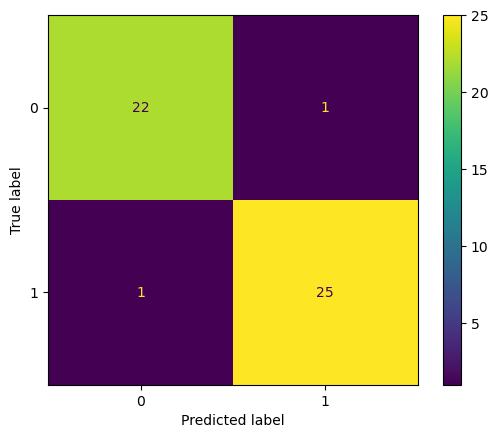

In [52]:
cm = confusion_matrix(results_df['True Label'], results_df['Predicted Label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

These evaluations of the BERT classifier show very similar results to the more simple models from earlier. We see that taking into account the entire detected text instead of only the gender ratio shows very good results as well. However the results are not better than with the decision stump or the logistic regression. I assume that the results could be improved a little by further preprocessing or more finetuning. However, it is likely that the results are just getting as good as those of the decision stump in the best case.

It arises the question whether it is worth spending a multiple of the computing resources to finetune a pretrained BERT classifier if that leads to the same results. I'm arguing that this is not the case. As we have seen throughout this notebook, we are dealing with a simple problem that asks for a simple solution, especially because we can achieve very high results with just using a single feature after clean data preprocessing and feature engineering. A further discussion is provided in the enclosed report on this project.